In [98]:
%matplotlib inline

In [99]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [100]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = './imgData/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=5,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes
print(class_names)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

['nonprog', 'prog']


Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



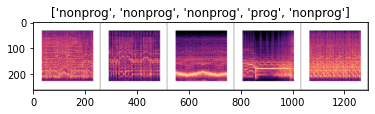

In [101]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [102]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    #print(outputs)
                    #print(labels)
                    loss = criterion(outputs, labels)
    
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [103]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)

            m = nn.Softmax(dim=1)
            proOutput = m(outputs)

            _, preds = torch.max(outputs, 1)
            pro = torch.max(proOutput, dim=1)[0]
            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: %s with %s probabilities' %(class_names[preds[j]], round(pro[j].item(),4)))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
                
        model.train(mode=was_training)

# visualize_model(model_ft)

Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [104]:
model_ft = models.resnet50(pretrained=True) #load resnet50.

num_ftrs = model_ft.fc.in_features

# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




In [105]:
ep = 1000
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=ep)

Epoch 1/1000
----------
train Loss: 0.7282 Acc: 0.6031
test Loss: 0.6267 Acc: 0.6562

Epoch 2/1000
----------
train Loss: 0.7448 Acc: 0.6684
test Loss: 0.8539 Acc: 0.6771

Epoch 3/1000
----------
train Loss: 0.6352 Acc: 0.7023
test Loss: 0.6612 Acc: 0.6875

Epoch 4/1000
----------
train Loss: 0.5627 Acc: 0.7937
test Loss: 0.8273 Acc: 0.7188

Epoch 5/1000
----------
train Loss: 0.6182 Acc: 0.7311
test Loss: 0.6362 Acc: 0.6875

Epoch 6/1000
----------
train Loss: 0.3391 Acc: 0.8381
test Loss: 0.7617 Acc: 0.7292

Epoch 7/1000
----------
train Loss: 0.4023 Acc: 0.8251
test Loss: 0.8797 Acc: 0.6354

Epoch 8/1000
----------
train Loss: 0.2631 Acc: 0.8747
test Loss: 0.7032 Acc: 0.7188

Epoch 9/1000
----------
train Loss: 0.2359 Acc: 0.8903
test Loss: 0.7515 Acc: 0.6979

Epoch 10/1000
----------
train Loss: 0.2219 Acc: 0.9243
test Loss: 0.6795 Acc: 0.7396

Epoch 11/1000
----------
train Loss: 0.1047 Acc: 0.9687
test Loss: 0.7612 Acc: 0.7396

Epoch 12/1000
----------
train Loss: 0.1278 Acc: 0.9

train Loss: 0.0897 Acc: 0.9687
test Loss: 0.7520 Acc: 0.7396

Epoch 96/1000
----------
train Loss: 0.0896 Acc: 0.9713
test Loss: 0.8213 Acc: 0.7083

Epoch 97/1000
----------
train Loss: 0.1206 Acc: 0.9661
test Loss: 0.7831 Acc: 0.7604

Epoch 98/1000
----------
train Loss: 0.1046 Acc: 0.9608
test Loss: 0.7908 Acc: 0.7500

Epoch 99/1000
----------
train Loss: 0.0630 Acc: 0.9817
test Loss: 0.8136 Acc: 0.7292

Epoch 100/1000
----------
train Loss: 0.0588 Acc: 0.9948
test Loss: 0.7335 Acc: 0.7396

Epoch 101/1000
----------
train Loss: 0.1060 Acc: 0.9687
test Loss: 0.7639 Acc: 0.7500

Epoch 102/1000
----------
train Loss: 0.0921 Acc: 0.9713
test Loss: 0.7861 Acc: 0.7396

Epoch 103/1000
----------
train Loss: 0.0790 Acc: 0.9869
test Loss: 0.7738 Acc: 0.7396

Epoch 104/1000
----------
train Loss: 0.0504 Acc: 0.9948
test Loss: 0.7998 Acc: 0.7500

Epoch 105/1000
----------
train Loss: 0.1120 Acc: 0.9687
test Loss: 0.8238 Acc: 0.7396

Epoch 106/1000
----------
train Loss: 0.1182 Acc: 0.9452
test 

test Loss: 0.7639 Acc: 0.7396

Epoch 189/1000
----------
train Loss: 0.1006 Acc: 0.9739
test Loss: 0.7829 Acc: 0.7396

Epoch 190/1000
----------
train Loss: 0.1201 Acc: 0.9608
test Loss: 0.7642 Acc: 0.7396

Epoch 191/1000
----------
train Loss: 0.0899 Acc: 0.9713
test Loss: 0.7839 Acc: 0.7396

Epoch 192/1000
----------
train Loss: 0.1123 Acc: 0.9582
test Loss: 0.7606 Acc: 0.7396

Epoch 193/1000
----------
train Loss: 0.1398 Acc: 0.9452
test Loss: 0.8247 Acc: 0.7188

Epoch 194/1000
----------
train Loss: 0.0637 Acc: 0.9817
test Loss: 0.7940 Acc: 0.7396

Epoch 195/1000
----------
train Loss: 0.1039 Acc: 0.9687
test Loss: 0.7601 Acc: 0.7292

Epoch 196/1000
----------
train Loss: 0.1024 Acc: 0.9713
test Loss: 0.7632 Acc: 0.7396

Epoch 197/1000
----------
train Loss: 0.0906 Acc: 0.9739
test Loss: 0.7842 Acc: 0.7396

Epoch 198/1000
----------
train Loss: 0.1080 Acc: 0.9661
test Loss: 0.7678 Acc: 0.7396

Epoch 199/1000
----------
train Loss: 0.0819 Acc: 0.9739
test Loss: 0.7785 Acc: 0.7396

E

train Loss: 0.0815 Acc: 0.9765
test Loss: 0.7922 Acc: 0.7396

Epoch 283/1000
----------
train Loss: 0.0811 Acc: 0.9765
test Loss: 0.7690 Acc: 0.7396

Epoch 284/1000
----------
train Loss: 0.1000 Acc: 0.9687
test Loss: 0.7811 Acc: 0.7500

Epoch 285/1000
----------
train Loss: 0.0905 Acc: 0.9687
test Loss: 0.7813 Acc: 0.7604

Epoch 286/1000
----------
train Loss: 0.0861 Acc: 0.9843
test Loss: 0.7733 Acc: 0.7292

Epoch 287/1000
----------
train Loss: 0.0881 Acc: 0.9687
test Loss: 0.7524 Acc: 0.7396

Epoch 288/1000
----------
train Loss: 0.0761 Acc: 0.9739
test Loss: 0.7674 Acc: 0.7396

Epoch 289/1000
----------
train Loss: 0.1048 Acc: 0.9608
test Loss: 0.7564 Acc: 0.7500

Epoch 290/1000
----------
train Loss: 0.0886 Acc: 0.9739
test Loss: 0.8140 Acc: 0.7292

Epoch 291/1000
----------
train Loss: 0.1239 Acc: 0.9556
test Loss: 0.8188 Acc: 0.7500

Epoch 292/1000
----------
train Loss: 0.0903 Acc: 0.9765
test Loss: 0.7396 Acc: 0.7500

Epoch 293/1000
----------
train Loss: 0.0741 Acc: 0.9739
t

test Loss: 0.7933 Acc: 0.7188

Epoch 376/1000
----------
train Loss: 0.1277 Acc: 0.9478
test Loss: 0.7780 Acc: 0.7500

Epoch 377/1000
----------
train Loss: 0.0877 Acc: 0.9765
test Loss: 0.7599 Acc: 0.7396

Epoch 378/1000
----------
train Loss: 0.0780 Acc: 0.9791
test Loss: 0.8021 Acc: 0.7188

Epoch 379/1000
----------
train Loss: 0.0752 Acc: 0.9817
test Loss: 0.7510 Acc: 0.7292

Epoch 380/1000
----------
train Loss: 0.0963 Acc: 0.9661
test Loss: 0.7562 Acc: 0.7396

Epoch 381/1000
----------
train Loss: 0.1190 Acc: 0.9582
test Loss: 0.8271 Acc: 0.7292

Epoch 382/1000
----------
train Loss: 0.1007 Acc: 0.9661
test Loss: 0.8016 Acc: 0.7292

Epoch 383/1000
----------
train Loss: 0.0704 Acc: 0.9869
test Loss: 0.7822 Acc: 0.7396

Epoch 384/1000
----------
train Loss: 0.0668 Acc: 0.9869
test Loss: 0.7539 Acc: 0.7292

Epoch 385/1000
----------
train Loss: 0.1132 Acc: 0.9582
test Loss: 0.7701 Acc: 0.7500

Epoch 386/1000
----------
train Loss: 0.0587 Acc: 0.9896
test Loss: 0.7549 Acc: 0.7292

E

train Loss: 0.1118 Acc: 0.9556
test Loss: 0.8061 Acc: 0.7604

Epoch 470/1000
----------
train Loss: 0.1199 Acc: 0.9608
test Loss: 0.7849 Acc: 0.7500

Epoch 471/1000
----------
train Loss: 0.0886 Acc: 0.9687
test Loss: 0.7826 Acc: 0.7292

Epoch 472/1000
----------
train Loss: 0.0732 Acc: 0.9791
test Loss: 0.7757 Acc: 0.7604

Epoch 473/1000
----------
train Loss: 0.0972 Acc: 0.9687
test Loss: 0.8380 Acc: 0.7292

Epoch 474/1000
----------
train Loss: 0.0684 Acc: 0.9843
test Loss: 0.7355 Acc: 0.7396

Epoch 475/1000
----------
train Loss: 0.1593 Acc: 0.9373
test Loss: 0.7800 Acc: 0.7188

Epoch 476/1000
----------
train Loss: 0.0938 Acc: 0.9687
test Loss: 0.7783 Acc: 0.7396

Epoch 477/1000
----------
train Loss: 0.0880 Acc: 0.9791
test Loss: 0.7865 Acc: 0.7396

Epoch 478/1000
----------
train Loss: 0.0973 Acc: 0.9713
test Loss: 0.7745 Acc: 0.7396

Epoch 479/1000
----------
train Loss: 0.1221 Acc: 0.9530
test Loss: 0.7667 Acc: 0.7396

Epoch 480/1000
----------
train Loss: 0.1170 Acc: 0.9530
t

test Loss: 0.7638 Acc: 0.7396

Epoch 563/1000
----------
train Loss: 0.1258 Acc: 0.9478
test Loss: 0.8170 Acc: 0.7396

Epoch 564/1000
----------
train Loss: 0.1532 Acc: 0.9347
test Loss: 0.7619 Acc: 0.7396

Epoch 565/1000
----------
train Loss: 0.1440 Acc: 0.9426
test Loss: 0.8034 Acc: 0.7396

Epoch 566/1000
----------
train Loss: 0.1206 Acc: 0.9634
test Loss: 0.7481 Acc: 0.7396

Epoch 567/1000
----------
train Loss: 0.0846 Acc: 0.9791
test Loss: 0.8064 Acc: 0.7188

Epoch 568/1000
----------
train Loss: 0.1086 Acc: 0.9713
test Loss: 0.7623 Acc: 0.7500

Epoch 569/1000
----------
train Loss: 0.0744 Acc: 0.9739
test Loss: 0.7738 Acc: 0.7500

Epoch 570/1000
----------
train Loss: 0.0858 Acc: 0.9739
test Loss: 0.7188 Acc: 0.7500

Epoch 571/1000
----------
train Loss: 0.0693 Acc: 0.9765
test Loss: 0.7797 Acc: 0.7396

Epoch 572/1000
----------
train Loss: 0.0617 Acc: 0.9896
test Loss: 0.7629 Acc: 0.7396

Epoch 573/1000
----------
train Loss: 0.0979 Acc: 0.9687
test Loss: 0.7592 Acc: 0.7500

E

train Loss: 0.1111 Acc: 0.9713
test Loss: 0.7813 Acc: 0.7500

Epoch 657/1000
----------
train Loss: 0.1165 Acc: 0.9608
test Loss: 0.8772 Acc: 0.7188

Epoch 658/1000
----------
train Loss: 0.1316 Acc: 0.9556
test Loss: 0.7874 Acc: 0.7500

Epoch 659/1000
----------
train Loss: 0.0792 Acc: 0.9765
test Loss: 0.7380 Acc: 0.7396

Epoch 660/1000
----------
train Loss: 0.0901 Acc: 0.9687
test Loss: 0.7733 Acc: 0.7292

Epoch 661/1000
----------
train Loss: 0.0978 Acc: 0.9634
test Loss: 0.7635 Acc: 0.7188

Epoch 662/1000
----------
train Loss: 0.0743 Acc: 0.9817
test Loss: 0.7621 Acc: 0.7396

Epoch 663/1000
----------
train Loss: 0.0619 Acc: 0.9843
test Loss: 0.7827 Acc: 0.7500

Epoch 664/1000
----------
train Loss: 0.0647 Acc: 0.9869
test Loss: 0.7827 Acc: 0.7292

Epoch 665/1000
----------
train Loss: 0.0581 Acc: 0.9843
test Loss: 0.7475 Acc: 0.7292

Epoch 666/1000
----------
train Loss: 0.1210 Acc: 0.9608
test Loss: 0.8179 Acc: 0.7500

Epoch 667/1000
----------
train Loss: 0.1045 Acc: 0.9634
t

test Loss: 0.8111 Acc: 0.7083

Epoch 750/1000
----------
train Loss: 0.1193 Acc: 0.9608
test Loss: 0.7706 Acc: 0.7500

Epoch 751/1000
----------
train Loss: 0.0836 Acc: 0.9687
test Loss: 0.7441 Acc: 0.7292

Epoch 752/1000
----------
train Loss: 0.0744 Acc: 0.9713
test Loss: 0.7523 Acc: 0.7500

Epoch 753/1000
----------
train Loss: 0.0742 Acc: 0.9869
test Loss: 0.7437 Acc: 0.7500

Epoch 754/1000
----------
train Loss: 0.0510 Acc: 0.9922
test Loss: 0.7546 Acc: 0.7396

Epoch 755/1000
----------
train Loss: 0.1000 Acc: 0.9608
test Loss: 0.7331 Acc: 0.7396

Epoch 756/1000
----------
train Loss: 0.0851 Acc: 0.9713
test Loss: 0.7850 Acc: 0.7396

Epoch 757/1000
----------
train Loss: 0.0721 Acc: 0.9817
test Loss: 0.8988 Acc: 0.7083

Epoch 758/1000
----------
train Loss: 0.1219 Acc: 0.9687
test Loss: 0.7701 Acc: 0.7396

Epoch 759/1000
----------
train Loss: 0.0997 Acc: 0.9739
test Loss: 0.7626 Acc: 0.7396

Epoch 760/1000
----------
train Loss: 0.0792 Acc: 0.9791
test Loss: 0.7994 Acc: 0.7396

E

train Loss: 0.0733 Acc: 0.9817
test Loss: 0.7661 Acc: 0.7500

Epoch 844/1000
----------
train Loss: 0.0895 Acc: 0.9817
test Loss: 0.7990 Acc: 0.7500

Epoch 845/1000
----------
train Loss: 0.0794 Acc: 0.9661
test Loss: 0.7600 Acc: 0.7292

Epoch 846/1000
----------
train Loss: 0.1202 Acc: 0.9582
test Loss: 0.8307 Acc: 0.7396

Epoch 847/1000
----------
train Loss: 0.0972 Acc: 0.9582
test Loss: 0.7549 Acc: 0.7396

Epoch 848/1000
----------
train Loss: 0.0704 Acc: 0.9765
test Loss: 0.7581 Acc: 0.7500

Epoch 849/1000
----------
train Loss: 0.1006 Acc: 0.9791
test Loss: 0.7589 Acc: 0.7604

Epoch 850/1000
----------
train Loss: 0.0862 Acc: 0.9765
test Loss: 0.7757 Acc: 0.7292

Epoch 851/1000
----------
train Loss: 0.0878 Acc: 0.9739
test Loss: 0.7572 Acc: 0.7396

Epoch 852/1000
----------
train Loss: 0.0700 Acc: 0.9843
test Loss: 0.7600 Acc: 0.7292

Epoch 853/1000
----------
train Loss: 0.0778 Acc: 0.9869
test Loss: 0.7608 Acc: 0.7396

Epoch 854/1000
----------
train Loss: 0.0730 Acc: 0.9791
t

test Loss: 0.7780 Acc: 0.7396

Epoch 937/1000
----------
train Loss: 0.1456 Acc: 0.9399
test Loss: 0.8316 Acc: 0.7188

Epoch 938/1000
----------
train Loss: 0.1261 Acc: 0.9478
test Loss: 0.7767 Acc: 0.7500

Epoch 939/1000
----------
train Loss: 0.0924 Acc: 0.9791
test Loss: 0.8360 Acc: 0.6979

Epoch 940/1000
----------
train Loss: 0.0897 Acc: 0.9608
test Loss: 0.7779 Acc: 0.7188

Epoch 941/1000
----------
train Loss: 0.0861 Acc: 0.9713
test Loss: 0.7746 Acc: 0.7188

Epoch 942/1000
----------
train Loss: 0.0741 Acc: 0.9843
test Loss: 0.7925 Acc: 0.7396

Epoch 943/1000
----------
train Loss: 0.1022 Acc: 0.9530
test Loss: 0.7662 Acc: 0.7396

Epoch 944/1000
----------
train Loss: 0.1153 Acc: 0.9687
test Loss: 0.7857 Acc: 0.7500

Epoch 945/1000
----------
train Loss: 0.0916 Acc: 0.9634
test Loss: 0.7865 Acc: 0.7500

Epoch 946/1000
----------
train Loss: 0.1050 Acc: 0.9713
test Loss: 0.7759 Acc: 0.7500

Epoch 947/1000
----------
train Loss: 0.0846 Acc: 0.9739
test Loss: 0.7699 Acc: 0.7604

E

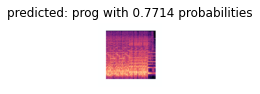

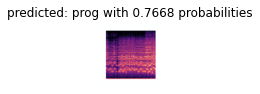

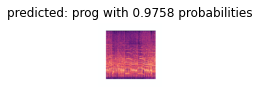

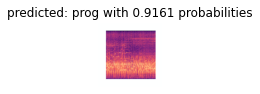

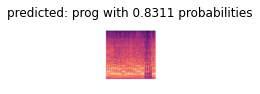

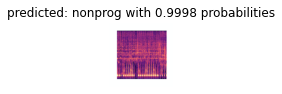

In [106]:
visualize_model(model_ft)

In [107]:
correct = 0
total = 0
nb_classes = 2
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['train']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s train images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix)
#print(confusion_matrix/(total/2)) #Normalizing

Accuracy of the network on the 383 train images: 100 %
tensor([[224.,   0.],
        [  0., 159.]])


In [108]:
correct = 0
total = 0
nb_classes = 2
confusion_matrix = torch.zeros(nb_classes, nb_classes)
with torch.no_grad():
    for data in dataloaders['test']:
        images, labels = data[0].cuda(), data[1].cuda()
        outputs = model_ft(images)
        predicted = torch.round(outputs)
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1
        

print('Accuracy of the network on the %s test images: %d %%' % (total,
    100 * correct / total))

print(confusion_matrix) 
#print(confusion_matrix/(total/5)) #Normalizing

Accuracy of the network on the 96 train images: 77 %
tensor([[43., 13.],
        [ 9., 31.]])


In [109]:
# PATH = './Resnet50EP%s.pth' %(ep)
# torch.save(model_ft.state_dict(), PATH)